In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
import cv2
from PIL import Image

In [3]:
import sys
sys.path.append("C:/git/computer-vision-control/")

# Read images

In [4]:
from glob import glob

In [5]:
hand_files = glob("C:/git/computer-vision-control/images/hand_detection/hand/*.png")
not_hand_files = glob("C:/git/computer-vision-control/images/hand_detection/not_hand/*.png")

In [6]:
len(hand_files)

319

In [7]:
len(not_hand_files)

312

# Camera Image

## Preprocessing

In [8]:
from vision_control.camera import *

In [36]:
img = CameraImage(file_path=hand_files[50])

In [39]:
img.preprocess(canny_intensity=30)

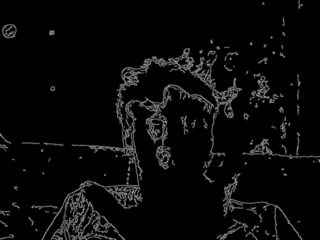

In [40]:
img

## Building the dataset

In [12]:
hand_img = [CameraImage(file_path = file_path,tag = 1,check = True) for file_path in tqdm(hand_files,desc = "Loading hand images")]
not_hand_img = [CameraImage(file_path = file_path,tag = 0,check = True) for file_path in tqdm(not_hand_files,desc = "Loading not hand images")]
all_img = hand_img + not_hand_img
all_img = [img for img in all_img if img.ok]

Loading not hand images: 100%|███████████████| 312/312 [00:04<00:00, 66.68it/s]


In [13]:
images = CameraImages(camera_images=all_img)

In [14]:
images.preprocess()

Preprocessing images: 100%|█████████████████| 629/629 [00:01<00:00, 358.40it/s]


In [46]:
X = images.build_X()

In [47]:
np.max(X)

0.85882352941176465

In [48]:
y = images.build_y()

In [49]:
y.shape

(629, 1)

# Train a simple model

In [17]:
# Keras
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop, Adam
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import model_from_json

Using TensorFlow backend.


## Creating the MLP

In [53]:
model = Sequential()
model.add(Dense(256,input_dim = X.shape[1],activation = "relu"))
# model.add(Dropout(0.25))
model.add(Dense(256,activation = "relu"))
# model.add(Dropout(0.25))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

In [54]:
model.fit(X,y,validation_split=0.1,epochs=2,verbose = 2)

Train on 566 samples, validate on 63 samples
Epoch 1/2
11s - loss: 0.3262 - acc: 0.8604 - val_loss: 0.3855 - val_acc: 0.8730
Epoch 2/2
10s - loss: 0.0123 - acc: 0.9947 - val_loss: 0.8200 - val_acc: 0.8254


In [61]:
pred = model.predict(X)

In [69]:
images[602].tag

0

In [71]:
images[602].predict(model)

0.7253291

In [67]:
np.round(pred,2)[602]

array([ 0.73000002], dtype=float32)

## Live test

In [107]:
test = CameraImage(capture = True)

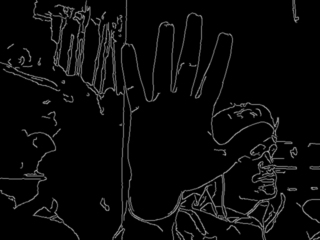

In [108]:
test.preprocess(canny_intensity=30)
test

In [110]:
test.predict(model)

0.0027017274

## Conclusion : 
The model fit very well on the train and dev set, but does not generalize to pictures in a production setting

## Saving the model

In [ ]:
model.save("model_")

# Train a more complex model : CNN

## Building a dataset not flattened

In [19]:
X = images.build_X(flatten=False)
X.shape

(629, 240, 320, 1)

## Creating the model

In [23]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=(240,320,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = Adam(lr=0.01)
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
model.fit(X,y,validation_split=0.3,epochs=1,verbose = 1)

Train on 440 samples, validate on 189 samples
Epoch 1/1
440/440 [==============================] - ETA: 297s - loss: 2.6747 - acc: 0.562 - ETA: 234s - loss: 3.3301 - acc: 0.656 - ETA: 202s - loss: 4.2129 - acc: 0.645 - ETA: 178s - loss: 4.5297 - acc: 0.648 - ETA: 156s - loss: 4.9191 - acc: 0.637 - ETA: 137s - loss: 4.6805 - acc: 0.661 - ETA: 117s - loss: 4.7235 - acc: 0.665 - ETA: 98s - loss: 4.4445 - acc: 0.687 - ETA: 80s - loss: 4.6703 - acc: 0.67 - ETA: 62s - loss: 4.5022 - acc: 0.69 - ETA: 45s - loss: 4.2287 - acc: 0.71 - ETA: 28s - loss: 4.2085 - acc: 0.71 - ETA: 12s - loss: 4.3063 - acc: 0.70 - 251s - loss: 4.1801 - acc: 0.7182 - val_loss: 15.9424 - val_acc: 0.0000e+00


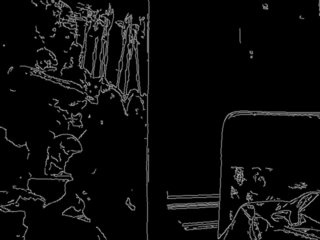

In [31]:
test = CameraImage(capture = True)
test.preprocess()
test

In [32]:
test.predict(model,flatten = False)

0.99779582